In [1]:
import pickle
import numpy as np
np.random.seed(42)

with open("embeddings2.pkl", 'rb') as f:
    X = pickle.load(f)[1:]
    
with open("categories.txt") as f:
    y = list(map(eval, f.readlines()))
    
y = np.array(y, dtype=object)

In [2]:
import pandas as pd

from sklearn.decomposition import PCA
X_2d = PCA(2).fit_transform(X)

X_2d = pd.DataFrame(X_2d, columns=['x1', 'x2'])

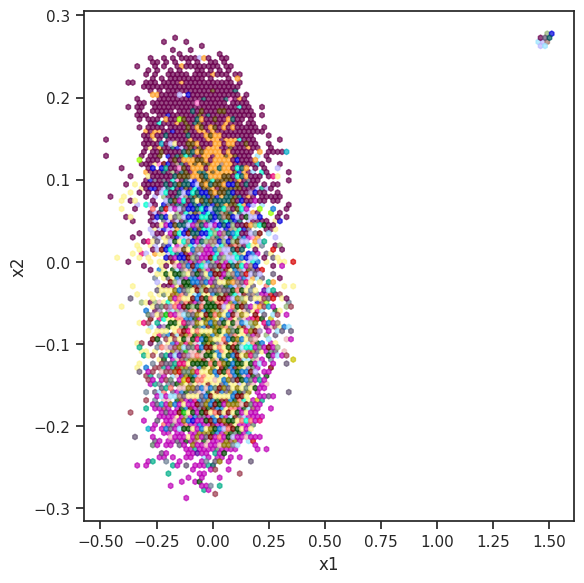

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

from matplotlib.colors import ListedColormap

sns.set_theme(style='ticks')

def factorize(x):
    invmap = {c: i for i, c in enumerate(set(x))}
    return [invmap[c] for c in x]

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
hue = [c[1] if len(c) > 1 else 'Other' for c in y]

cmap = ListedColormap(sns.color_palette(cc.glasbey, n_colors=len(set(hue))).as_hex())
hb = ax.hexbin(x=X_2d['x1'], y=X_2d['x2'], C=factorize(hue), alpha=0.7, cmap=cmap)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
fig.tight_layout()

In [4]:
for i in X_2d[X_2d['x1'] > 1].index[:10]:
    print(y[i])

['Sports & Outdoors', 'Team Sports', 'Baseball', 'Accessories', 'Equipment Bags', 'Bat Bags']
['Sports & Outdoors', 'Accessories']
['Sports & Outdoors', 'Hunting & Fishing', 'Hunting', 'Gun Accessories', 'Grips']
['Sports & Outdoors', 'Leisure Sports & Game Room', 'Outdoor Games & Activities', 'Disc Sports', 'Disc Golf']
['Sports & Outdoors', 'Outdoor Gear', 'Camping & Hiking', 'Camp Bedding', 'Air Mattresses']
['Sports & Outdoors', 'Team Sports', 'Soccer', 'Clothing', 'Men', 'Socks']
['Sports & Outdoors', 'Outdoor Gear', 'Camping & Hiking', 'Lights & Lanterns', 'Headlamps']
['Sports & Outdoors', 'Outdoor Gear', 'Camping & Hiking', 'Knives & Tools', 'Folding Knives']
['Sports & Outdoors', 'Hunting & Fishing', 'Hunting', 'Gun Accessories', 'Grips']
['Sports & Outdoors', 'Clothing', 'Men', 'Shirts']


In [5]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from itertools import zip_longest
from collections import defaultdict

from numpy.typing import NDArray


KNNTree = tuple[KNeighborsClassifier, dict]


class HierarchicalKNN:
    def __init__(
        self, 
        labels: list[list], 
        k_neigh: int = 5, 
        metric = 'cosine',
        min_samples_to_train: int = 20,
    ) -> None:
        self.ltree = self._build_ltree(labels)
        
        self.k_neigh = k_neigh
        self.metric = metric
        self.min_samples_to_train = max(min_samples_to_train, self.k_neigh)
        self.max_depth = max(map(len, labels))
    
    def _build_ltree(self, y: list) -> dict:
        subcats = defaultdict(list)
        
        for cats in filter(None, y):
            subcats[cats[0]].append(None if len(cats) < 2 else cats[1:])

        tree = {p: (i+1, self._build_ltree(s)) 
                for i, (p, s) in enumerate(subcats.items())}
        return tree
    
    def _build_itree(self, y: list, ltree: dict) -> dict: 
        subidx = dict()
        indices = defaultdict(list)
        labels = []
        
        for i, cats in enumerate(y):
            if not cats:
                labels.append(0)
            else:
                f, lsubtree = ltree[cats[0]]
                labels.append(f)
                
                if f not in subidx: 
                    subidx[f] = ([], lsubtree)
                    
                subidx[f][0].append(cats[1:])
                indices[f].append(i)
            
        tree = {f: (*self._build_itree(c, t), indices[f]) 
                for f, (c, t) in subidx.items()}
        return labels, tree
        
    def _fit(
        self, 
        itree: dict, 
        X: NDArray, 
        y: NDArray
    ) -> KNNTree:
        if not itree or X.shape[0] < self.min_samples_to_train:
            return None
        
        knn = KNeighborsClassifier(
            n_neighbors=self.k_neigh, 
            metric=self.metric
        ).fit(X, y)      
         
        tree = {i: self._fit(subtree, X[idx], l)
                for i, (l, subtree, idx) in itree.items()}
        return (knn, tree)
        
    def fit(self, X, y):
        labels, self.itree = self._build_itree(y, self.ltree)
        self.knn_tree = self._fit(self.itree, X, labels)
        return self
    
    def _predict(
        self, 
        knn_tree: KNNTree, 
        X: NDArray, 
        depth: int
    ) -> NDArray:
        y = np.zeros((X.shape[0], 1))
        
        if not knn_tree or X.shape[0] == 0:
            return y
        
        knn, tree = knn_tree
        pred = knn.predict(X)
        
        next_p = np.zeros((X.shape[0], self.max_depth - depth))
        
        for p, subtree in tree.items():
            y[pred == p] = p
            new_p = self._predict(subtree, X[pred == p], depth+1)
            next_p[pred == p] = new_p
        
        return np.concat([y, next_p], axis=1)
    
    def predict(self, X):
        return self._predict(self.knn_tree, X, depth=0)[:, :self.max_depth]

    def _to_indices(self, y: list, ltree):    
        if not y: 
            return []
        
        new_idx, subtree = ltree[y[0]]
        return [new_idx] + self._to_indices(y[1:], subtree) if y else []

    def to_indices(self, y: list):
        idx = [self._to_indices(c, self.ltree) for c in y]
        return np.array(list(zip_longest(*idx, fillvalue=0))).T

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score
from functools import partial

@partial(np.vectorize, excluded=[0], signature='(n),(n),(n)->()')
def reduce_level(fn, y_true, y_pred, mask):
    return fn(y_true[mask], y_pred[mask])

def compute_metric(fn, y_true, y_pred):
    mask = y_true.astype(bool) | y_pred.astype(bool)
    return reduce_level(fn, y_true.T, y_pred.T, mask.T), mask.sum(axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

model = HierarchicalKNN(y, k_neigh=8).fit(X_train, y_train)

idx_pred = model.predict(X_test)
idx_true = model.to_indices(y_test)

fn = partial(f1_score, average='macro')
# fn = partial(precision_score, average='macro', zero_division=0)

for level, (score, n) in enumerate(zip(*compute_metric(fn, idx_true, idx_pred))):
    print(f"Level {level+1} f1-score: {score:.2f} (n={n})")

Level 1 f1-score: 0.20 (n=3672)
Level 2 f1-score: 0.37 (n=3671)
Level 3 f1-score: 0.19 (n=3671)
Level 4 f1-score: 0.12 (n=3629)
Level 5 f1-score: 0.10 (n=3028)
Level 6 f1-score: 0.07 (n=845)
Level 7 f1-score: 0.00 (n=25)


In [7]:
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm

def masked_accuracy(y_true, y_pred):
    mask = y_true.astype(bool) | y_pred.astype(bool)
    return np.mean(np.sum((y_true == y_pred) * mask, axis=1) / np.sum(mask, axis=1))

kf = KFold(shuffle=True, random_state=42)
accuracy = 0.0

for train_idx, test_idx in tqdm(kf.split(X, y)):
    X_train, y_train = X[train_idx], y[train_idx]
    X_test, y_test = X[test_idx], y[test_idx]
    
    hknn = HierarchicalKNN(y, k_neigh=10).fit(X_train, y_train)
    
    idx_pred = hknn.predict(X_test)
    idx_true = hknn.to_indices(y_test)
    
    accuracy += masked_accuracy(idx_true, idx_pred)
    
print(f"accuracy: {accuracy / 5:.2%}")

0it [00:00, ?it/s]

accuracy: 56.63%
